# Presenting SOTA results on CIMA dataset

This notebook serves as visualisation for State-of-the-Art methods on CIMA dataset

_Note: In case you want to get some further evaluation related to new submission, you may contact JB._

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os, sys
import glob, json
import shutil

import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path += [os.path.abspath('.'), os.path.abspath('..')]  # Add path to root
from birl.utilities.data_io import update_path
from birl.utilities.evaluate import compute_ranking
from birl.utilities.drawing import RadarChart, draw_scatter_double_scale
from bm_ANHIR.generate_regist_pairs import VAL_STATUS_TRAIN, VAL_STATUS_TEST
from bm_ANHIR.evaluate_submission import COL_TISSUE

/home/jb/.local/lib/python3.6/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


This notebook serves for computing extended statistics (e.g. metrics inliding ranks) and visualie some more statistics.


You can run the notebook to see result on both scales `10k` and `full`.
To do so you need to unzip paticular archive in `bm_CIMA` to a separate folder and point-out this path as `PATH_RESULTS` bellow.

In [2]:
# folder with all participants submissions
PATH_RESULTS = os.path.join(update_path('bm_CIMA'), 'size-10k')
# temporary folder for unzipping submissions
PATH_TEMP = os.path.abspath(os.path.expanduser('~/Desktop/CIMA_size-10k'))
# configuration needed for recomputing detail metrics
PATH_DATASET = os.path.join(update_path('bm_ANHIR'), 'dataset_ANHIR')
PATH_TABLE = os.path.join(update_path('bm_CIMA'), 'dataset_CIMA_10k.csv')
# landmarks provided to participants, in early ANHIR stage we provided only 20% points per image pair
PATH_LNDS_PROVIDED = os.path.join(PATH_DATASET, 'landmarks_all')
# complete landmarks dataset
PATH_LNDS_COMPLATE = os.path.join(PATH_DATASET, 'landmarks_all')
# baseline for normalization of computing time
PATH_COMP_BM = os.path.join(PATH_DATASET, 'computer-performances_cmpgrid-71.json')
FIELD_TISSUE = 'type-tissue'

# configuration for Pandas tables
pd.set_option("display.max_columns", 25)
assert os.path.isdir(PATH_TEMP)

Some initial replacement and name adjustments

In [3]:
# simplify the metrics names according paper
METRIC_LUT = {'Average-': 'A', 'Rank-': 'R', 'Median-': 'M', 'Max-': 'S'}

def col_metric_rename(col):
    for m in METRIC_LUT:
        col = col.replace(m, METRIC_LUT[m])
    return col

## Parse and load submissions

### Extract metrics from particular submissions

All submissions are expected to be as a zip archives in single folder. The archive name is the author name.

In [4]:
# Find all archives and unzip them to the same folder.
archive_paths = sorted(glob.glob(os.path.join(PATH_RESULTS, '*.zip')))
submission_dirs = []

for path_zip in tqdm.tqdm(archive_paths, desc='unzipping'):
    sub = os.path.join(PATH_TEMP, os.path.splitext(os.path.basename(path_zip))[0])
    os.system('unzip -o "%s" -d "%s"' % (path_zip, sub))
    sub_ins = glob.glob(os.path.join(sub, '*'))
    # if the zip subfolder contain only one folder move it up
    if len(sub_ins) == 1:
        [shutil.move(p, sub) for p in glob.glob(os.path.join(sub_ins[0], '*'))]
    submission_dirs.append(sub)

unzipping: 100%|██████████| 7/7 [00:00<00:00, 12.23it/s]


Parse submissions and compute the final metrics. This can be computed just once.

**NOTE:** you can skip this step if you have already computed metrics in JSON files

In [5]:
import bm_ANHIR.evaluate_submission

bm_ANHIR.evaluate_submission.REQUIRE_OVERLAP_INIT_TARGET = False

tqdm_bar = tqdm.tqdm(total=len(submission_dirs))
for path_sub in submission_dirs:
    tqdm_bar.set_description(path_sub)
    # run the evaluation with details
    path_json = bm_ANHIR.evaluate_submission.main(
        path_experiment=path_sub, path_table=PATH_TABLE, path_dataset=PATH_LNDS_PROVIDED,
        path_reference=PATH_LNDS_COMPLATE, path_comp_bm=PATH_COMP_BM, path_output=path_sub,
        min_landmarks=1., details=True, allow_inverse=True)
    # rename the metrics by the participant
    shutil.copy(os.path.join(path_sub, 'metrics.json'),
                os.path.join(PATH_RESULTS, os.path.basename(path_sub) + '.json'))
    tqdm_bar.update()

### Load parsed measures from each experiment

In [4]:
submission_paths = sorted(glob.glob(os.path.join(PATH_RESULTS, '*.json')))
submissions = {}
# loading all participants metrics
for path_sub in tqdm.tqdm(submission_paths, desc='loading'):
    with open(path_sub, 'r') as fp:
        metrics = json.load(fp)
    # rename tissue types accoding new LUT
    for case in metrics['cases']:
        metrics['cases'][case][FIELD_TISSUE] = metrics['cases'][case][FIELD_TISSUE]
    m_agg = {stat: metrics['aggregates'][stat] for stat in metrics['aggregates']}
    metrics['aggregates'] = m_agg
    submissions[os.path.splitext(os.path.basename(path_sub))[0]] = metrics

print ('Users: %r' % submissions.keys())

loading: 100%|██████████| 7/7 [00:00<00:00, 252.21it/s]

Users: dict_keys(['ANTs', 'DROP', 'Elastix', 'RNiftyReg', 'RVSS', 'bUnwarpJ-SIFT', 'bUnwarpJ'])


In [5]:
# split the particular fields inside the measured items
users = list(submissions.keys())
print ('Fields: %r' % submissions[users[0]].keys())
user_aggreg = {u: submissions[u]['aggregates'] for u in users}
user_computer = {u: submissions[u]['computer'] for u in users}
user_cases = {u: submissions[u]['cases'] for u in users}
print ('required-landmarks: %r' % [submissions[u]['required-landmarks'] for u in users])
tissues = set(user_cases[users[0]][cs][FIELD_TISSUE] for cs in user_cases[users[0]])
print ('found tissues: %r' % sorted(tissues))

Fields: dict_keys(['aggregates', 'cases', 'computer', 'submission-time', 'required-landmarks'])
required-landmarks: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
found tissues: ['lung-lesion', 'lung-lobes', 'mammary-gland']


Define colors and markers later used in charts

In [6]:
METHODS = sorted(submissions.keys())
# https://seaborn.pydata.org/tutorial/color_palettes.html
# https://www.codecademy.com/articles/seaborn-design-ii
COLOR_PALETTE = "Set1"
METHOD_CMAP = sns.color_palette(COLOR_PALETTE, len(submissions))
METHOD_COLORS = {m: METHOD_CMAP[i] for i, m in enumerate(METHODS)}

def list_methods_colors(methods):
    return [METHOD_COLORS[m] for m in methods]

def cmap_methods(method):
    return METHOD_COLORS[m]

# define cyclic buffer of markers for methods
# https://matplotlib.org/3.1.1/api/markers_api.html
METHOD_MARKERS = dict(zip(submissions.keys(), list('.*^v<>pPhHXdD')))
# METHOD_MARKERS = dict(zip(submissions.keys(), list('.1234+xosD^v<>')))

def list_methods_markers(methods):
    return [METHOD_MARKERS[m] for m in methods]

# display(pd.DataFrame([METHOD_COLORS, METHOD_MARKERS]).T)

## Compute ranked measures

Extend the aggregated statistic by Rank measures such as compute ranking over all cases for each selected field and average it

In [7]:
for field, field_agg in [('rTRE-Median', 'Median-rTRE'),
                         ('rTRE-Max', 'Max-rTRE')]:
    # Compute ranking per user in selected metric `field` over all dataset
    user_cases = compute_ranking(user_cases, field)
    for user in users:
        # iterate over Robust or all cases
        for robust in [True, False]:
            # chose inly robyst if it is required
            vals = [user_cases[user][cs][field + '_rank'] for cs in user_cases[user]
                    if (robust and user_cases[user][cs]['Robustness']) or (not robust)]
            s_robust = '-Robust' if robust else ''
            user_aggreg[user]['Average-Rank-' + field_agg + s_robust] = np.mean(vals)
            user_aggreg[user]['STD-Rank-' + field_agg + s_robust] = np.std(vals)
        # iterate over all tissue kinds
        for tissue in tissues:
            vals = [user_cases[user][cs][field + '_rank'] for cs in user_cases[user]
                    if user_cases[user][cs][FIELD_TISSUE] == tissue]
            user_aggreg[user]['Average-Rank-' + field_agg + '_tissue_' + tissue] = np.mean(vals)
            user_aggreg[user]['STD-Rank-' + field_agg + '_tissue_' + tissue] = np.std(vals)

Show the raw table with **global** statistic (joint training and testing/evaluation).

In [8]:
cols_all = [col for col in pd.DataFrame(user_aggreg).T.columns 
                if not any(n in col for n in [VAL_STATUS_TRAIN, VAL_STATUS_TEST, '_tissue_', '_any'])]
cols_general = list(filter(lambda c: not c.endswith('-Robust'), cols_all))
dfx = pd.DataFrame(user_aggreg).T.sort_values('Average-Median-rTRE')[cols_general]
display(dfx)
# Exporting results to CSV
dfx.sort_index().to_csv(os.path.join(PATH_TEMP, 'results_overall.csv'))

,Average-used-landmarks,Average-Robustness,STD-Robustness,Median-Robustness,Average-Rank-Median-rTRE,Average-Rank-Max-rTRE,Average-Median-rTRE,STD-Median-rTRE,Median-Median-rTRE,Average-Max-rTRE,STD-Max-rTRE,Median-Max-rTRE,Average-Average-rTRE,STD-Average-rTRE,Median-Average-rTRE,Average-Norm-Time,STD-Norm-Time,Median-Norm-Time,STD-Rank-Median-rTRE,STD-Rank-Max-rTRE
ANTs,1.0,0.790214,0.248232,0.892468,3.342593,2.824074,0.023031,0.020008,0.016662,0.055601,0.036617,0.050011,0.024131,0.019472,0.018600,52.167229,26.893003,60.916335,1.564431,1.489648
DROP,1.0,0.842451,0.304637,0.986842,2.296296,2.564815,0.025039,0.051129,0.005084,0.062894,0.079209,0.029880,0.026894,0.051019,0.006521,1.856635,0.844369,2.160855,2.042417,2.148527
bUnwarpJ,1.0,0.740683,0.277490,0.831250,3.601852,3.824074,0.028214,0.020833,0.030013,0.066614,0.036561,0.064172,0.029630,0.020194,0.031437,2.989572,1.125316,2.933392,1.855621,1.762935
RNiftyReg,1.0,0.680507,0.296854,0.702044,4.222222,4.064815,0.031981,0.019345,0.032205,0.068474,0.034884,0.068234,0.033036,0.019073,0.034479,0.364217,0.598157,0.045782,1.517389,1.760014
Elastix,1.0,0.795504,0.164782,0.807692,4.527778,5.000000,0.037900,0.028974,0.034742,0.082920,0.044742,0.075468,0.039706,0.028133,0.037397,4.024381,0.754311,4.254518,1.807691,1.563472
RVSS,1.0,0.574520,0.289345,0.541241,4.981481,4.462963,0.059515,0.158266,0.032394,0.094764,0.165354,0.063392,0.060600,0.157822,0.034269,1.499862,0.825750,1.229713,1.747917,1.734326
bUnwarpJ-SIFT,1.0,0.496952,0.383557,0.540145,5.027778,5.259259,0.074338,0.079285,0.042298,0.135266,0.122401,0.096839,0.077425,0.080656,0.046481,2.659866,1.165022,2.708990,1.863183,1.796964


Only **robust** metrics (computed over images pairs with robustness higher then a threshold)

In [9]:
cols_robust = list(filter(lambda c: c.endswith('-Robust'), cols_all))
dfx = pd.DataFrame(user_aggreg).T.sort_values('Average-Median-rTRE')[cols_robust]
dfx.columns = list(map(lambda c: c.replace('-Robust', ''), dfx.columns))
display(dfx)

,Average-Median-rTRE,STD-Median-rTRE,Median-Median-rTRE,Average-Max-rTRE,STD-Max-rTRE,Median-Max-rTRE,Average-Average-rTRE,STD-Average-rTRE,Median-Average-rTRE,Average-Norm-Time,STD-Norm-Time,Median-Norm-Time,Average-Rank-Median-rTRE,STD-Rank-Median-rTRE,Average-Rank-Max-rTRE,STD-Rank-Max-rTRE
ANTs,0.019158,0.017901,0.012060,0.051248,0.036556,0.041127,0.020362,0.017289,0.014229,50.306482,27.266031,55.401263,3.342593,1.564431,2.824074,1.489648
DROP,0.006222,0.007302,0.004133,0.035815,0.034673,0.024499,0.008198,0.008946,0.005886,1.926173,0.821015,2.271720,2.029412,1.768215,2.313725,1.935126
bUnwarpJ,0.024697,0.020917,0.021041,0.062631,0.038681,0.057320,0.026341,0.020400,0.023998,2.945704,1.038554,2.902659,3.601852,1.855621,3.824074,1.762935
RNiftyReg,0.029002,0.020507,0.030274,0.066526,0.038920,0.066252,0.030126,0.020228,0.032280,0.382616,0.612680,0.045494,4.188679,1.505419,4.028302,1.750782
Elastix,0.035819,0.028515,0.032164,0.081753,0.045233,0.071432,0.037716,0.027670,0.034383,4.007976,0.758227,3.978500,4.527778,1.807691,5.000000,1.563472
RVSS,0.029296,0.024597,0.021571,0.064435,0.045133,0.050208,0.030293,0.024747,0.023583,1.456545,0.747360,1.343542,4.913462,1.743728,4.375000,1.705125
bUnwarpJ-SIFT,0.032093,0.018648,0.034173,0.076951,0.034319,0.073679,0.034356,0.017777,0.034625,2.896436,1.167257,2.824024,4.505882,1.766509,4.800000,1.761016


Define color and markers per method which shall be used later...

In [10]:
col_ranking = 'Average-Rank-Median-rTRE'
dfx = pd.DataFrame(user_aggreg).T.sort_values(col_ranking)
# display(dfx[[col_ranking]])
users_ranked = dfx.index
print('Odered methods by "%s": %s' % (col_ranking, list(users_ranked)))

Odered methods by "Average-Rank-Median-rTRE": ['DROP', 'ANTs', 'bUnwarpJ', 'RNiftyReg', 'Elastix', 'RVSS', 'bUnwarpJ-SIFT']


## Basic visualizations

Show general results in a chart...

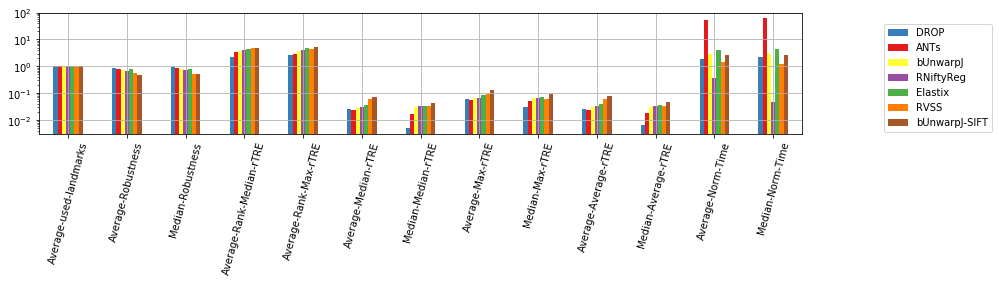

In [11]:
dfx = pd.DataFrame(user_aggreg)[users_ranked].T[list(filter(lambda c: not c.startswith('STD-'), cols_general))]
ax = dfx.T.plot.bar(figsize=(len(cols_general) * 0.7, 4), grid=True, logy=True, rot=75, color=list_methods_colors(dfx.index))
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),
#           ncol=int(len(users) / 1.5), fancybox=True, shadow=True)
ax.legend(bbox_to_anchor=(1.1, 0.95))
ax.get_figure().tight_layout()
ax.get_figure().savefig(os.path.join(PATH_TEMP, 'bars_teams-scores.pdf'))
# plt.savefig(os.path.join(PATH_TEMP, 'fig_teams-scores.pdf'), constrained_layout=True)

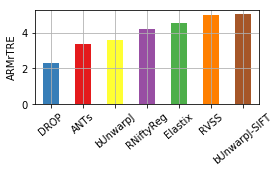

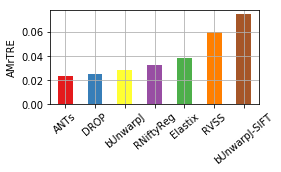

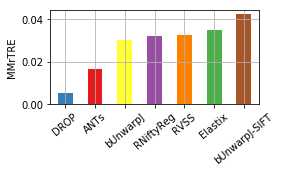

In [12]:
for col, name in [('Average-Rank-Median-rTRE', 'ARMrTRE'),
                  ('Average-Median-rTRE', 'AMrTRE'),
                  ('Median-Median-rTRE', 'MMrTRE')]:
    plt.figure(figsize=(4, 2.5))
    dfx = pd.DataFrame(user_aggreg)[users_ranked].T[col].sort_values()
    ax = dfx.plot.bar(grid=True, rot=40, color=list_methods_colors(dfx.index))
    # ax = pd.DataFrame(user_aggreg).T.sort_values(col)[col].plot.bar(grid=True, rot=90, color='blue')
    _= plt.ylabel(name)
    ax.get_figure().tight_layout()
    ax.get_figure().savefig(os.path.join(PATH_TEMP, 'bar_teams-scores_%s.pdf' % col))

Transform the case format data to be simple form with extra colums for used and case ID to be able to draw a violine plot later.

In [13]:
dfs_ = []
for usr in users:
    df = pd.DataFrame(user_cases[usr]).T
    df['method'] = usr
    df['case'] = df.index
    dfs_.append(df)
df_cases = pd.concat(dfs_).reset_index()
del dfs_

for col in df_cases.columns:
    try:
        df_cases[col] = pd.to_numeric(df_cases[col])
    except Exception:
        print('skip not numerical column: "%s"' % col)
# df_cases.head()

skip not numerical column: "name-tissue"
skip not numerical column: "type-tissue"
skip not numerical column: "name-reference"
skip not numerical column: "name-source"
skip not numerical column: "method"


### Showing several distribution plots

In [14]:
def _format_ax(ax, name, use_log=False, vmax=None):
    plt.xticks(rotation=60)
    if use_log:
        ax.set_yscale('log')
    if vmax:
        ax.set_ylim([0, vmax])
    ax.grid(True)
    ax.set_xlabel('')
    ax.set_ylabel(name)
    ax.get_figure().tight_layout()

show_metrics = [('rTRE-Median', 'MrTRE', True, None, 0.01),
                ('rTRE-Max', 'SrTRE', True, None, 0.01),
                ('Robustness', 'Robust.', False, None, 0.05),
                ('Norm-Time_minutes', 'Time [min]', True, 180, 0.1)]

/home/jb/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


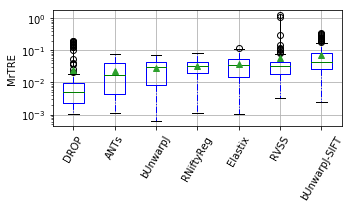

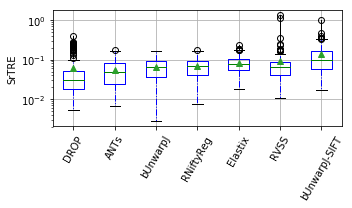

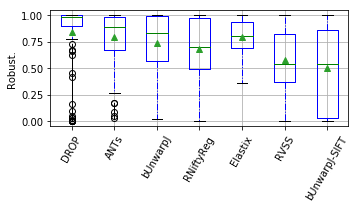

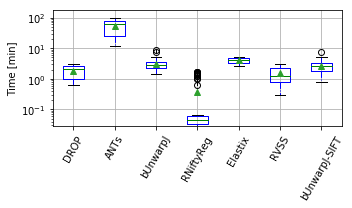

In [15]:
for field, name, log, vmax, bw in show_metrics:
    # methods_ = list(dfg['method'].unique())
    vals_ = [df_cases[df_cases['method'] == m][field].values for m in users_ranked]
    df_ = pd.DataFrame(np.array(vals_).T, columns=users_ranked)
    fig, ax = plt.subplots(figsize=(5, 3))
    bp = df_.plot.box(ax=ax, showfliers=True, showmeans=True, 
                      color=dict(boxes='b', whiskers='b', medians='g', caps='k'),
                      boxprops=dict(linestyle='-', linewidth=1),
                      flierprops=dict(linestyle='-', linewidth=1),
                      medianprops=dict(linestyle='-', linewidth=1),
                      whiskerprops=dict(linestyle='-.', linewidth=1),
                      capprops=dict(linestyle='-', linewidth=1),
                      return_type='dict')
    _format_ax(ax, name, log, vmax)
    ax.get_figure().savefig(os.path.join(PATH_TEMP, 'boxbar_teams-scores_%s.pdf' % field))

/home/jb/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


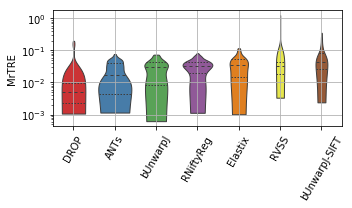

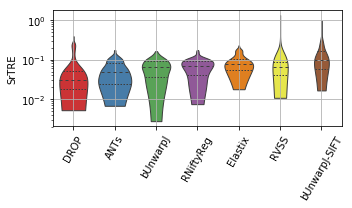

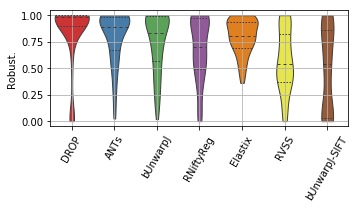

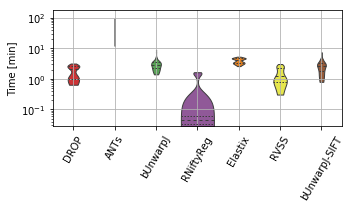

In [16]:
for field, name, log, vmax, bw in show_metrics:
    # methods_ = list(dfg['method'].unique())
    vals_ = [df_cases[df_cases['method'] == m][field].values for m in users_ranked]
    df_ = pd.DataFrame(np.array(vals_).T, columns=users_ranked)
    
    fig = plt.figure(figsize=(5, 3))
    # clr = sns.palplot(sns.color_palette(tuple(list_methods_colors(df_.columns))))
    ax = sns.violinplot(ax=plt.gca(), data=df_, inner="quartile", trim=True, cut=0., palette=COLOR_PALETTE, linewidth=1.)
    _format_ax(fig.gca(), name, log, vmax)
    fig.gca().grid(True)
    fig.savefig(os.path.join(PATH_TEMP, 'violin_teams-scores_%s.pdf' % field))

### Visualise global results

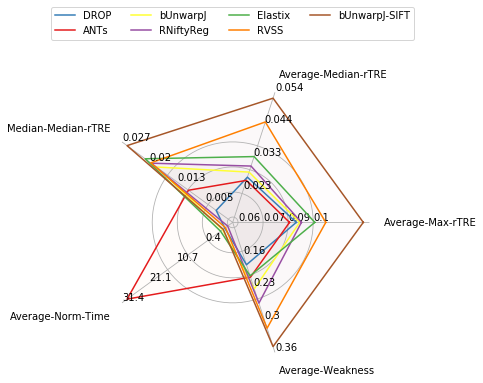

In [17]:
fields = ['Average-Max-rTRE', # 'Average-Max-rTRE-Robust',
          'Average-Median-rTRE', # 'Average-Median-rTRE-Robust',
          'Median-Median-rTRE', # 'Median-Median-rTRE-Robust',
          # 'Average-Rank-Max-rTRE', 'Average-Rank-Median-rTRE',
          'Average-Norm-Time', # 'Average-Norm-Time-Robust',
          'Average-Robustness',]
df = pd.DataFrame(user_aggreg)[users_ranked].T[fields]
df['Average-Weakness'] = 1 - df['Average-Robustness']
del df['Average-Robustness']

radar = RadarChart(df, fig=plt.figure(figsize=(5, 4)), colors=list_methods_colors(df.index), fill_alpha=0.02)
lgd = radar.ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.15), ncol=int(len(users) / 1.5))
radar.fig.savefig(os.path.join(PATH_TEMP, 'radar_teams-scores.pdf'),
                  bbox_extra_artists=radar._labels + [lgd], bbox_inches='tight')

### Visual statistic over tissue types

Present some statistis depending on the tissue types...

In [18]:
cols_all = pd.DataFrame(user_aggreg).T.columns
col_avg_med_tissue = sorted(filter(
    lambda c: 'Median-rTRE_tissue' in c and not 'Rank' in c and 'Median-Median-' not in c, cols_all))
col_robust_tissue = sorted(filter(
    lambda c: 'Average-Robustness_tissue' in c and not 'Rank' in c, cols_all))

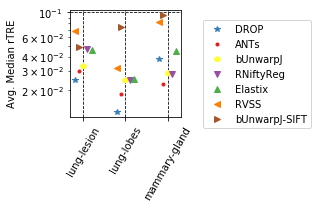

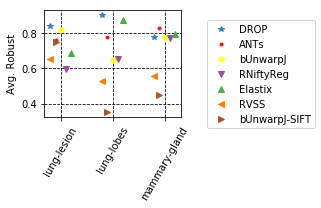

In [19]:
params_tuple = [
    (col_avg_med_tissue, 'Avg. Median rTRE', 'Average-Median-rTRE_tissue_', True),
    (col_robust_tissue,'Avg. Robust', 'Average-Robustness_tissue_', False),
]

for cols, desc, drop, use_log in params_tuple:
    # print('"%s" with sample columns: %s' % (desc, cols[:3]))
    dfx = pd.DataFrame(user_aggreg)[users_ranked].T[cols]
    # colors = plt.get_cmap('nipy_spectral', len(dfx))
    fig, extras = draw_scatter_double_scale(
        dfx, colors=list_methods_colors(users_ranked), ax_decs={desc: None},
        idx_markers=list_methods_markers(users_ranked), xlabel='Methods', figsize=(2 + len(dfx.columns) * 0.95, 3),
        # legend_style=dict(bbox_to_anchor=(0.5, 1.15), ncol=4),
        legend_style=dict(bbox_to_anchor=(1.15, 0.95), ncol=1),
        x_spread=(0.4, 5))
    
    # DEPRICATED visualisation
    # ax = dfx.T.plot(style='X', cmap=plt.get_cmap('nipy_spectral', len(dfx)), figsize=(len(dfx) / 2 + 1, 5), grid=True)
    # ax.legend(loc='upper center', bbox_to_anchor=(1.2, 1.0), ncol=1)
    extras['ax1'].set_xticks(range(len(cols)))
    extras['ax1'].set_xticklabels(list(map(lambda c: col_metric_rename(c.replace(drop, '')), cols)), rotation=45, ha="center")
    _format_ax(extras['ax1'], desc, use_log, vmax=None)
    
    name = ''.join(filter(lambda s: s not in '(.)', desc)).replace(' ', '-')
    fig.savefig(os.path.join(PATH_TEMP, 'scat_teams-scores_tissue-%s.pdf' % name),
                bbox_extra_artists=(extras['legend'],), bbox_inches='tight')  # 